#####  DNN기반 다중 분류 모델 구현
- 데이터 셋 : iris.csv
- 피쳐/속성 : 4개 Sepal_Length, Sepal_Width, Petal_Length, Petal_Width
- 타겟/라벨 : 1개 variety
- 학습-방법 : 지도학습 > 분류 > 다중분류 (클래스 3개 )
- 알고 리즘 : 인공신경망(ANN) -> MLP, DNN : 은닉층이 많은 구성 
- 프레임워크 : Pytorch

[1] 모듈 로딩 및 데이터 준비 <hr>

In [1]:
# 모듈 로딩
# - Model관련
import torch              
import torch.nn as nn              
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader 
import torch.optim as optim    
from torchmetrics.classification import MulticlassF1Score
from torchinfo import summary 

#- Data 및 시각화 관련
import pandas as pd 
import matplotlib.pyplot as plt              
from sklearn.preprocessing import * 
from sklearn.model_selection import train_test_split

In [2]:
# 활용 패키지 버전 체크 ==> 사용자 정의함수로 구현하세요~!!
print(f'Pytorch v.{torch.__version__}')
print(f'Pandas  v.{pd.__version__}')

Pytorch v.2.4.1
Pandas  v.2.0.3


In [3]:
###  데이터 로딩
DATA_FILE= r'C:\Users\KDP-43\Desktop\머신러닝_1\data\iris.csv' 

### CSV >>> DataFrame
irisDF = pd.read_csv(DATA_FILE)

### 확인
irisDF.head(1)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa


In [4]:
### 타겟 변경 => 정수화 , 클래스 3개 
irisDF['variety'].unique()

array(['Setosa', 'Versicolor', 'Virginica'], dtype=object)

In [5]:
labels=dict(zip(irisDF['variety'].unique().tolist(),range(3)))
print(f'labels =>{labels}')

irisDF['variety']=irisDF['variety'].replace(labels)
irisDF.head(1)

labels =>{'Setosa': 0, 'Versicolor': 1, 'Virginica': 2}


,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,0


[2] 모델 클래스 설계 및 정의 <hr>
- 클래스목적 : iris 데이터를 학습 및 추론 목적
- 클래스이름 : IrisMCFModel
- 부모클래스 : nn.Module
- 매개__변수 : 층별 입출력 개수 고정하기때문에 필요 없음!
- 속성__필드 : 
- 기능__역할 : __init__() : 모델 구조 설정 ,  forward() : 순방향 학습 <= 오바라이딩(overriding)
- 클래스구조 
    * 입력층 : 입력  4개(피쳐)      출력    10개 (퍼셉트론/뉴런 10개 존재)
    * 은닉층 : 입력 10개            출력    5개  (퍼셉트론/뉴런 5개 존재)
    * 출력층 : 입력  5개            출력    3개  (퍼셉트론/뉴런 2개 존재 : 다중분류)
- 활성화함수
    * 클래스 형태 ==> nn.MESLoss, nn.ReLU ==> __init__() 메서드 
    * 함수 형태 ==> torch.nn.functional 아래에  ==> forward()메서드

In [6]:
class IrisMCFModel(nn.Module):
    
    # 모델 구조 구성 및 인스턴스 생성 메서드
    def __init__(self):
        super().__init__()
        self.in_layer=nn.Linear(4, 10)
        self.hd_layer=nn.Linear(10, 5)
        self.out_layer=nn.Linear(5, 3)   # 다중분류 'Setosa', 'Versicolor', 'Virginica'
        
    # 순방향 학습 진행 메서드
    def forward(self, input_data):
        #- 입력층
        y=self.in_layer(input_data)   
        y=F.relu(y)                   
        
        # - 은닉층 : 10개의 숫자 값(>=0)
        y=self.hd_layer(y)            
        y=F.relu(y)                  
        
        #- 출력층 : 5개의 숫자 값 => 다중 분류 
        #- 손실함수 CrossEntropyLoss가 내부에서 softmax 진행 
        return self.out_layer(y)       


In [7]:
### [테스트] 모델 인스턴스 생성
model = IrisMCFModel()
print(model)

IrisMCFModel(
  (in_layer): Linear(in_features=4, out_features=10, bias=True)
  (hd_layer): Linear(in_features=10, out_features=5, bias=True)
  (out_layer): Linear(in_features=5, out_features=3, bias=True)
)


In [8]:
### [테스트] 모델 사용 메모리 정보 확인
summary(model, input_size=(5000000,4))

Layer (type:depth-idx)                   Output Shape              Param #
IrisMCFModel                             [5000000, 3]              --
├─Linear: 1-1                            [5000000, 10]             50
├─Linear: 1-2                            [5000000, 5]              55
├─Linear: 1-3                            [5000000, 3]              18
Total params: 123
Trainable params: 123
Non-trainable params: 0
Total mult-adds (M): 615
Input size (MB): 80.00
Forward/backward pass size (MB): 720.00
Params size (MB): 0.00
Estimated Total Size (MB): 800.00

[3] 데이터셋 클래스 설계 및 정의 <hr>

In [9]:
class IrisDataset(Dataset):
    def __init__(self, featureDF, targetDF):
        self.featureDF=featureDF 
        self.targetDF=targetDF
        self.n_rows=featureDF.shape[0]
        self.n_features=featureDF.shape[1]
    
    def __len__(self):
        return self.n_rows
    
    def __getitem__(self, index):
        # 텐서화
        featureTS=torch.FloatTensor(self.featureDF.iloc[index].values)
        targetTS=torch.FloatTensor(self.targetDF.iloc[index].values) 
        
        # 피쳐와 타겟 반환
        return featureTS, targetTS

In [10]:
## [테스트] 데이터셋 인스턴스 생성

# - DataFram에서 피쳐와 타겟 추출
featureDF = irisDF[irisDF.columns[:-1]]   # 2D (150, 3)
targetDF = irisDF[irisDF.columns[-1:]]    # 2D (150, 1)

# - 커스텀데이터셋 인스턴스 생성
irisDS=IrisDataset(featureDF, targetDF)

# - 데이터로더 인스턴스 생성 
irisDL = DataLoader(irisDS)
for feature, label in irisDL: 
    print(feature.shape, label.shape, feature, label)
    break

torch.Size([1, 4]) torch.Size([1, 1]) tensor([[5.1000, 3.5000, 1.4000, 0.2000]]) tensor([[0.]])


[4] 학습 준비 <hr>
- 학습_횟수 : EPOCH         <- 처음~끝까지 공부하는 단위
- 배치_크기 : BATCH_SIZE    <- 한번에 학습할 데이터셋 양 
- 위치_지정 : DEVICE    <- 텐서 저장 및 실행 위치 (GPU/CPU)
- 학_습_률 : LR 가중치와 절편 업데이트 시 경사하강법으로 업데이트 간격 설정 0.001~0.1 

In [11]:
### 학습 진행 관련 설정
EPOCH = 1000
BATCH_SIZE = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 0.001

- 인스턴스/객체 : 모델, 데이터셋, 최적화 (, 손실함수, 성능지표)

In [12]:
# 모델 인스턴스
model=IrisMCFModel()

In [13]:
# DS과 DL 인스턴스
#- 학습용, 검즈용, 테스트용 데이터 분리
X_train, X_test, y_train, y_test =train_test_split(featureDF, targetDF, 
                                                   stratify = targetDF,random_state=1)
X_train, X_val, y_train, y_val =train_test_split(X_train, y_train, 
                                                 stratify=y_train, random_state=1)

print(f'{X_train.shape} {X_test.shape} {X_val.shape}')
print(f'{y_train.shape} {y_test.shape} {y_val.shape}')
print(f'{y_train.value_counts()} {y_test.value_counts()} {y_val.value_counts()}')

# - 학습용, 검증용, 테스트용 데이터셋
trainDS=IrisDataset(X_train, y_train)
valDS=IrisDataset(X_val, y_val)
testDS=IrisDataset(X_test, y_test)

# - 학습용 데이터로더 인스턴스
trainDL=DataLoader(trainDS, batch_size=BATCH_SIZE)

(84, 4) (38, 4) (28, 4)
(84, 1) (38, 1) (28, 1)
variety
0          28
1          28
2          28
Name: count, dtype: int64 variety
1          13
2          13
0          12
Name: count, dtype: int64 variety
0          10
1           9
2           9
Name: count, dtype: int64


- 최적화, 손실함수 인스턴스 생성

In [14]:
# 최적화 인스턴스 => W,b 텐서 즉, model.parameters() 전달
optimizer=optim.Adam(model.parameters(), lr=LR)

# 손실함수 인스턴스 => 분류 => 다중분류 CrossEntropyLoss
#                            예측값은 선형식 결과 값 전달 ==> AF 처리 X
crossLoss=nn.CrossEntropyLoss()

[5] 학습 진행 <hr>

- > 모델 저장 준비

In [15]:
import os

# 저장 경로
SAVE_PATH = r'C:/Users/KDP-43/Desktop/딥러닝/0919/models/iris/MCF/'

# 모델 구조 & 파라미터 모두 저장
SAVE_MODEL = 'MCFmodel_all.pth'


In [16]:
# 경로상 폴더 존재 여부 체크
# 없으면 생성
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

- > 학습 진행

In [17]:
## 학습의 효과 확인 손실값과 성능평가값 저장 필요
LOSS_HISTORY, SCORE_HISTORY=[[],[]], [[],[]]
CNT=len(trainDL)
print(f'BATCH_CNT => {CNT}')

## 학습 모니터링 설정 -------------------------------------
BREAK_CNT = 0
LIMIT_VALUE = 30

for epoch in range(EPOCH):
    # 학습 모드로 모델 설정
    model.train()
    
    # 배치 크기 만큼 데이터 로딩해서 학습 진행
    loss_total, score_total=0,0
    for featureTS, targetTS in trainDL:
        # 학습 진행
        pre_y=model(featureTS)
        
        # 손실 계산 : nn.CrossEntropyLoss 요구사항 : 정답/타겟은 0D 또는 1D,  타입은 long
        loss=crossLoss(pre_y, targetTS.reshape(-1).long())
        loss_total += loss.item()
        
        # 성능평가 계산
        score=MulticlassF1Score(num_classes=3)(pre_y, targetTS.reshape(-1))
        score_total += score.item()
        
        # 최적화 진행
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # 에포크 당 검증기능
    # 모델 검증 모드 설정
    model.eval()
    with torch.no_grad():
        # 검증 데이터셋
        val_featrueTS=torch.FloatTensor(valDS.featureDF.values)
        val_targetTS=torch.FloatTensor(valDS.targetDF.values)
        
        # 추론/평가
        pre_val=model(val_featrueTS)
        print(pre_val.shape, val_targetTS.reshape(-1).shape)
        
        # 손실
        loss_val=crossLoss(pre_val, val_targetTS.reshape(-1).long())
        score_val=MulticlassF1Score(num_classes=3)(pre_val, val_targetTS.reshape(-1))

    # 에포크 당 손실값과 성능평가값 저장    
    LOSS_HISTORY[0].append(loss_total/CNT)
    SCORE_HISTORY[0].append(score_total/CNT)
    
    LOSS_HISTORY[1].append(loss_val)
    SCORE_HISTORY[1].append(score_val)
    
    print(f'[{epoch}/{EPOCH}]\n- [TRAIN] LOSS : {LOSS_HISTORY[0][-1]} SCORE : {SCORE_HISTORY[0][-1]}')
    print(f'- [VALID] LOSS : {LOSS_HISTORY[1][-1]} SCORE : {SCORE_HISTORY[1][-1]}')


	# 학습 진행 모티너링 --------------------------------------------
    # 검증 DS SCORE 기준

    if len(SCORE_HISTORY[1]) > 1:
        if SCORE_HISTORY[1][-1] <= SCORE_HISTORY[1][-2]:
            BREAK_CNT +=1
            
	# 좋은 성능 학습 모델 & 파라미터 저장
    SAVE_FILE = f'MCFModel_trian_wb_{epoch}_{score_val:.4f}.pth'
    
    if len(SCORE_HISTORY[1]) == 1:
        torch.save(model.state_dict(), SAVE_PATH+SAVE_FILE)
        torch.save(model, SAVE_PATH+SAVE_MODEL)
        
    else:
        # 현재 모델의 검증 모델 점수가 이전 최고성능 점수보다 높으면 저장
        torch.save(model.state_dict(), SAVE_PATH+SAVE_FILE)
        torch.save(model, SAVE_PATH+SAVE_MODEL)

	# 학습 중단 여부 결정
    if BREAK_CNT > LIMIT_VALUE:
        print(f"score 개선 변화가 없어 {epoch} EPOCH에서 학습을 중단.")
        break

        

BATCH_CNT => 9
torch.Size([28, 3]) torch.Size([28])
[0/1000]
- [TRAIN] LOSS : 1.2078599797354803 SCORE : 0.15880971236361396
- [VALID] LOSS : 1.1799174547195435 SCORE : 0.1621621698141098
torch.Size([28, 3]) torch.Size([28])
[1/1000]
- [TRAIN] LOSS : 1.1805090241962009 SCORE : 0.15880971236361396
- [VALID] LOSS : 1.1586191654205322 SCORE : 0.1621621698141098
torch.Size([28, 3]) torch.Size([28])
[2/1000]
- [TRAIN] LOSS : 1.1628711488511827 SCORE : 0.15880971236361396
- [VALID] LOSS : 1.1470683813095093 SCORE : 0.1621621698141098
torch.Size([28, 3]) torch.Size([28])
[3/1000]
- [TRAIN] LOSS : 1.1529299285676744 SCORE : 0.15880971236361396
- [VALID] LOSS : 1.1395617723464966 SCORE : 0.1621621698141098
torch.Size([28, 3]) torch.Size([28])
[4/1000]
- [TRAIN] LOSS : 1.145100752512614 SCORE : 0.15880971236361396
- [VALID] LOSS : 1.1322294473648071 SCORE : 0.1621621698141098
torch.Size([28, 3]) torch.Size([28])
[5/1000]
- [TRAIN] LOSS : 1.1383183532290988 SCORE : 0.15880971236361396
- [VALID] L

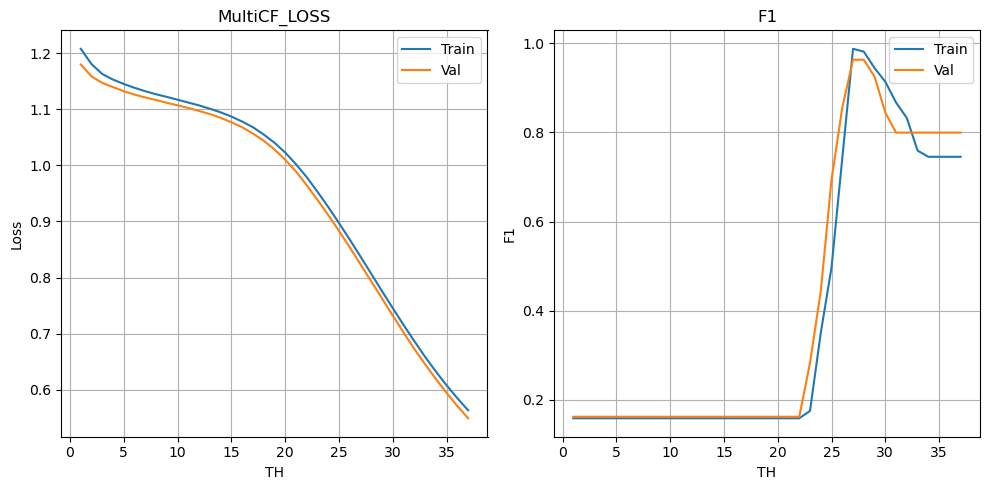

In [18]:
from utils import showLossScore

showLossScore(SCORE_HISTORY, LOSS_HISTORY, title1='MultiCF_LOSS', title2='F1')

In [ ]:
# 학습 후 loss 시각화
import matplotlib.pyplot as plt

fg, axes=plt.subplots(1,2, figsize=(10,5), sharex=True)
fg.suptitle('IRIS Loss & R2')

axes[0].plot(range(1, EPOCH+1), LOSS_HISTORY[0][:EPOCH], label='Train')
axes[0].plot(range(1, EPOCH+1), LOSS_HISTORY[1][:EPOCH], label='Val')
axes[0].grid()
axes[0].legend()
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("LOSS")

axes[1].plot(range(1, EPOCH+1), SCORE_HISTORY[0][:EPOCH], label='Train')
axes[1].plot(range(1, EPOCH+1), SCORE_HISTORY[1][:EPOCH], label='Val')
axes[1].grid()
axes[1].legend()
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("F1")
axes[1].set_title("F1")

plt.tight_layout()
plt.show()

In [ ]:
# 모델 검증 모드 설정
model.eval()
with torch.no_grad():
    # 검증 데이터셋
    test_featrueTS=torch.FloatTensor(testDS.featureDF.values)
    test_targetTS=torch.FloatTensor(testDS.targetDF.values)
        
    # 추론/평가
    pre_val=model(test_featrueTS)
    
    # 손실
    loss_test=crossLoss(pre_val, test_targetTS.reshape(-1).long())
    score_test=MulticlassF1Score(num_classes=3)(pre_val, test_targetTS.reshape(-1))
    
print(f'- [TEST] LOSS : {loss_test.item()} SCORE : {score_test.item()}')